In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Problem 1

In [3]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    #the number of the prob when we get heads
    success_num = np.random.binomial(n,p)
    #set the range 0 - 1
    p_val = np.linspace(0,1,100)
    #binomial pmf
    prob_p = [(p**success_num)*((1-p)**(n-success_num))for p in p_val]
    #integrating the sum of pmf
    int_p = np.sum(prob_p)
    #find the max index
    max_index = np.argmax(prob_p/int_p)
    #get the max value out of the index
    MAP = p_val[max_index]
    
    #plot the graph
    x_axis = p_val
    y_axis = prob_p/int_p
    plt.plot(x_axis, y_axis, 'k.')
    plt.show()
    
    return MAP   

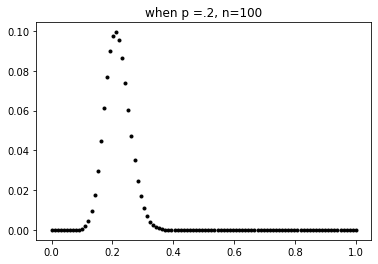

0.21212121212121213

In [4]:
plt.title("when p =.2, n=100")
bernoulli_sampling(.2,100)

# Problem 2

In [5]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    #the number of the prob when we get heads
    success_num = np.random.binomial(n,p)
    #set the range 0 - 1
    p_val = np.linspace(0,1,100)
    #binomial pmf
    prob_p = [(p**success_num)*((1-p)**(n-success_num))*prior.pdf(p)for p in p_val]
    #integrating the sum of pmf
    int_p = np.sum(prob_p)
    #find the max index
    max_index = np.argmax(prob_p/int_p)
    #get the max value out of the index
    MAP = p_val[max_index]
    
    #plot the graph
    x_axis = p_val
    y_axis = prob_p/int_p
    plt.plot(x_axis, y_axis, 'k.')
    plt.show()
    
    return MAP 
    

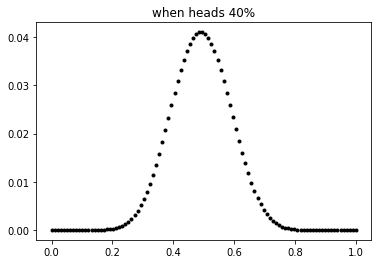

0.48484848484848486

In [6]:
plt.title("when heads 40%")
non_uniform_prior(0.4,20,beta(5,1.5))

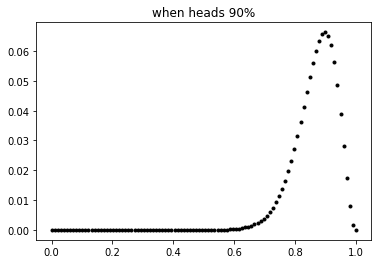

0.8989898989898991

In [7]:
plt.title("when heads 90%")
non_uniform_prior(0.9,20,beta(5,1.5))

# Problem 3

In [8]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    #The array of the weather
    labels = ["sun", "rain", "wind"]
    #0th day
    curr_weather = "sun"
    #The array of possible forecast of the 10 following days
    foll_days = []
    for i in range(10):
        index = np.random.choice(len(labels), p = transition_matrix[labels.index(curr_weather)])
        curr_weather = labels[index]
        foll_days.append(curr_weather)
        
    return foll_days
    

In [9]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

weather_forecast(transition_matrix, 10)

['rain', 'rain', 'rain', 'rain', 'rain', 'sun', 'sun', 'wind', 'rain', 'sun']

# Problem 4

In [10]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
        #prior distribution = beta(1,1)
        lam = pm.Beta('prior distribution', alpha = 1,beta = 1)
        #posterior distribution = bernoulli(lam, data)
        y = pm.Bernoulli('y', p=lam, observed=data)
        trace = pm.sample(n)
        
        #plotting
        az.plot_trace(trace)
        lam = trace['prior distribution']
        mean = lam.mean()
    return mean

<ipython-input-10-1624e038aed1>:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior distribution]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


0.1555095190644476

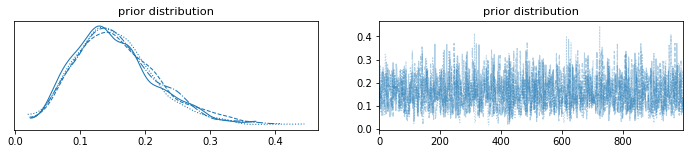

In [11]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data)

# Problem 5

In [12]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        #Normal(m,s)
        mu = pm.Normal('mu', mu=m, sigma = s)
        #Gamma(alpha,beta)
        tau = pm.Gamma('tau', alpha = alpha,beta = beta)
        #posterior distribution
        y = pm.Normal('y', mu=mu, sigma = 1/tau, observed=data)
        trace = pm.sample(n)
        #plotting
        az.plot_trace(trace)
        lam = trace['mu']
        mean = lam.mean()
    return mean

<ipython-input-12-442db472dc3f>:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


159.68087463303948

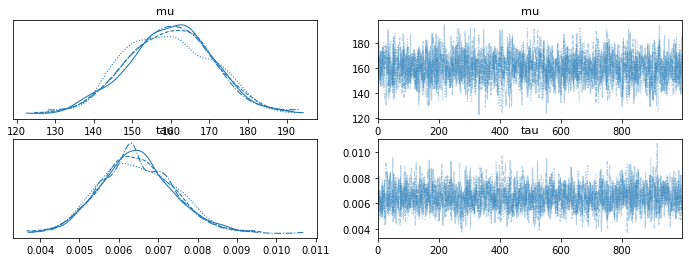

In [13]:
heights = np.random.normal(180,10,100)
height_model(heights)